# 04 — Evaluation & Testing (Chapter 4)

In [8]:
# ============================================================
# BLOK 0: DRIVE + PATH SETUP (Evaluation & Testing)
# ============================================================

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path

BASE_DIR  = Path("/content/drive/MyDrive/Student-Stress-Academic-Performance")
MODEL_DIR = BASE_DIR / "models"
DATA_PATH = BASE_DIR / "processed_student_mental_health.csv"

FIG_DIR   = BASE_DIR / "outputs" / "figures"
TAB_DIR   = BASE_DIR / "outputs" / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR :", BASE_DIR)
print("MODEL_DIR:", MODEL_DIR)
print("DATA_PATH:", DATA_PATH)
print("FIG_DIR  :", FIG_DIR)
print("TAB_DIR  :", TAB_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR : /content/drive/MyDrive/Student-Stress-Academic-Performance
MODEL_DIR: /content/drive/MyDrive/Student-Stress-Academic-Performance/models
DATA_PATH: /content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv
FIG_DIR  : /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures
TAB_DIR  : /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables


In [9]:
# ============================================================
# BLOK 1: LOAD TEST SPLIT (split_pack)
# ============================================================

import joblib
import pandas as pd

split_path = MODEL_DIR / "split_pack.joblib"

if not split_path.exists():
    raise FileNotFoundError(
        f"split_pack bulunamadı: {split_path}\n"
        "Çözüm: 02_Supervised_Models dosyasında split_pack.joblib kaydet."
    )

split_pack = joblib.load(split_path)
X_test = split_pack["X_test"]
y_test = split_pack["y_test"]

print("Loaded split_pack.")
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Loaded split_pack.
X_test: (21, 5) y_test: (21,)


In [10]:
# ============================================================
# BLOK 2: LOAD SAVED MODELS
# ============================================================

models = {}

def try_load(name, filename):
    p = MODEL_DIR / filename
    if p.exists():
        models[name] = joblib.load(p)
        print(f"Loaded: {name} -> {p}")
    else:
        print(f"Skipped (not found): {name} -> {p}")

try_load("Logistic Regression", "logreg_pipeline.joblib")
try_load("Decision Tree",        "dt_model.joblib")
try_load("Naive Bayes",          "nb_model.joblib")
try_load("k-NN",                 "knn_model.joblib")
try_load("Random Forest",        "rf_model.joblib")

if len(models) == 0:
    raise RuntimeError(
        "Hiç model yüklenemedi. models/ klasörüne joblib model dosyaları kaydedilmemiş.\n"
        "Çözüm: 02_Supervised_Models dosyasında joblib.dump ile kaydet."
    )


Loaded: Logistic Regression -> /content/drive/MyDrive/Student-Stress-Academic-Performance/models/logreg_pipeline.joblib
Skipped (not found): Decision Tree -> /content/drive/MyDrive/Student-Stress-Academic-Performance/models/dt_model.joblib
Skipped (not found): Naive Bayes -> /content/drive/MyDrive/Student-Stress-Academic-Performance/models/nb_model.joblib
Skipped (not found): k-NN -> /content/drive/MyDrive/Student-Stress-Academic-Performance/models/knn_model.joblib
Skipped (not found): Random Forest -> /content/drive/MyDrive/Student-Stress-Academic-Performance/models/rf_model.joblib


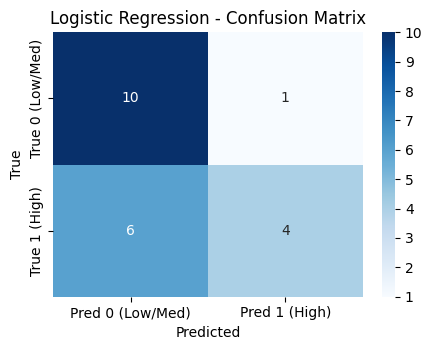


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0     0.6250    0.9091    0.7407        11
           1     0.8000    0.4000    0.5333        10

    accuracy                         0.6667        21
   macro avg     0.7125    0.6545    0.6370        21
weighted avg     0.7083    0.6667    0.6420        21


=== Supervised Model Comparison ===
                 Model  Accuracy  Precision  Recall        F1
0  Logistic Regression  0.666667        0.8     0.4  0.533333
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/supervised_model_comparison.csv


In [11]:
# ============================================================
# BLOK 3: CLASSIFICATION METRICS + CONFUSION MATRICES
# - metrics table (csv)
# - confusion matrix figures (png)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4.6, 3.6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
        yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
    )
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    fig_name = f"CM_{name.replace(' ', '_').replace('-', '')}.png"
    plt.savefig(FIG_DIR / fig_name, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))

# Results table
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("\n=== Supervised Model Comparison ===")
print(results_df)

results_df.to_csv(TAB_DIR / "supervised_model_comparison.csv", index=False)
print("Saved:", TAB_DIR / "supervised_model_comparison.csv")


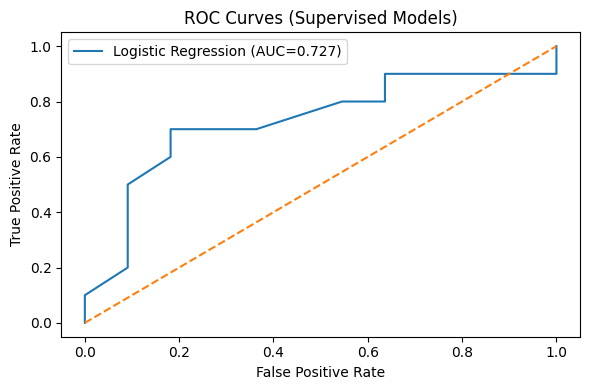


=== ROC/AUC Results ===
                 Model   ROC_AUC
0  Logistic Regression  0.727273
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/ROC_Curves.png
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/roc_auc_results.csv


In [12]:
# ============================================================
# BLOK 4: ROC/AUC + ROC CURVES (save figure + csv)
# ============================================================

from sklearn.metrics import roc_auc_score, roc_curve

def get_score(model, X):
    """ROC için olasılık/score üretir."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

auc_rows = []

plt.figure(figsize=(6, 4))

for name, model in models.items():
    y_score = get_score(model, X_test)

    if y_score is None:
        print(f"{name}: ROC/AUC hesaplanamadı (predict_proba/decision_function yok).")
        continue

    auc = roc_auc_score(y_test, y_score)
    auc_rows.append({"Model": name, "ROC_AUC": auc})

    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Supervised Models)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR / "ROC_Curves.png", dpi=300, bbox_inches="tight")
plt.show()

auc_df = pd.DataFrame(auc_rows).sort_values("ROC_AUC", ascending=False)
print("\n=== ROC/AUC Results ===")
print(auc_df)

auc_df.to_csv(TAB_DIR / "roc_auc_results.csv", index=False)
print("Saved:", FIG_DIR / "ROC_Curves.png")
print("Saved:", TAB_DIR / "roc_auc_results.csv")


In [13]:
# ============================================================
# BLOK 5: LOAD UNSUPERVISED COMPARISON (from 03 outputs)
# ============================================================

unsup_path = TAB_DIR / "unsupervised_model_comparison.csv"

if unsup_path.exists():
    unsup_df = pd.read_csv(unsup_path)
    print("\n=== Unsupervised Model Comparison (Loaded) ===")
    print(unsup_df)
else:
    print("Unsupervised comparison table not found:", unsup_path)
    print("Çözüm: 03_Unsupervised_Methods dosyasını çalıştırıp tabloyu üret.")



=== Unsupervised Model Comparison (Loaded) ===
         Method  Clusters  Silhouette Noise Detected Interpretability
0       K-Means         3    0.525997             No         Moderate
1  Hierarchical         3    0.528438             No             High
2        DBSCAN         7    1.000000       Yes (3%)              Low


In [14]:
# ============================================================
# BLOK 6: EXPORT FINAL SUMMARY FILES (optional)
# ============================================================

# Supervised results already saved:
# - supervised_model_comparison.csv
# - roc_auc_results.csv
# Unsupervised already saved:
# - unsupervised_model_comparison.csv

print("\nOutputs ready for report:")
print("-", TAB_DIR / "supervised_model_comparison.csv")
print("-", TAB_DIR / "roc_auc_results.csv")
print("-", TAB_DIR / "unsupervised_model_comparison.csv")
print("- ROC fig:", FIG_DIR / "ROC_Curves.png")
print("- CM figs: outputs/figures/CM_*.png")



Outputs ready for report:
- /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/supervised_model_comparison.csv
- /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/roc_auc_results.csv
- /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/unsupervised_model_comparison.csv
- ROC fig: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/ROC_Curves.png
- CM figs: outputs/figures/CM_*.png
